# 1. Data preprocessing

In [1]:
import pandas as pd
import json

In [2]:
ENC = json.loads(open('/media/Z/NDT/Transformer_Tabular/GBDT/Ensemble learning/encoding.json').read())

In [3]:
df_train = pd.read_csv('/media/Z/NDT/Transformer_Tabular/dataset/train.csv')
df_test = pd.read_csv('/media/Z/NDT/Transformer_Tabular/dataset/test.csv')
df_val = pd.read_csv('/media/Z/NDT/Transformer_Tabular/dataset/val.csv')

In [4]:
CATEGORY_FEATURES = df_train.columns.difference(df_train.select_dtypes('float').columns).tolist()
NUMBER_FEATURES = list(set(df_train.columns) - set(CATEGORY_FEATURES))
CATEGORY_FEATURES.remove('income_bracket')

In [5]:
def ordinal_encoding(df: pd.DataFrame, category_features: list, encoding: dict) -> pd.DataFrame:
    df_ = df.copy()
    for c in CATEGORY_FEATURES:
        df_[c] = df_[c].map(encoding[c])
    return df_
        

In [6]:
X_train = df_train.drop('income_bracket', axis=1)
y_train = df_train.income_bracket
X_val = df_val.drop('income_bracket', axis=1)
y_val = df_val.income_bracket
X_test = df_test.drop('income_bracket', axis=1)
y_test = df_test.income_bracket

In [7]:
FEATURES = X_train.columns.tolist()

In [8]:
X_train_encoding = ordinal_encoding(X_train, CATEGORY_FEATURES, ENC)
X_val_encoding = ordinal_encoding(X_val, CATEGORY_FEATURES, ENC)
X_test_encoding = ordinal_encoding(X_test, CATEGORY_FEATURES, ENC)

# 2. Modeling

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
Model = GradientBoostingClassifier()

In [11]:
Model.fit(X_train_encoding, y_train)
y_pred = Model.predict(X_test_encoding)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     12435
           1       0.79      0.59      0.68      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.77      0.80     16281
weighted avg       0.86      0.87      0.86     16281



## 3. Tuning Model

In [13]:
import hyperopt
import numpy as np

def hyperopt_objective(params):
    model = GradientBoostingClassifier(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'] + 1, # condition >= 1
        max_depth=params['max_depth']+1, # condition >= 1
    )
    
    model.fit(X_train_encoding, y_train)
    y_pred = model.predict(X_val_encoding)
    f1 = f1_score(y_val, y_pred)
    return 1 - f1  # as hyperopt minimises

In [14]:
params_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'n_estimators': hyperopt.hp.randint('n_estimators', 200),
    'max_depth': hyperopt.hp.randint('max_depth', 20),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(123)
)

print(best)

100%|██████████| 100/100 [15:11<00:00,  9.11s/trial, best loss: 0.2766393442622951]
{'learning_rate': 0.12363869941322762, 'max_depth': 5, 'n_estimators': 142}


In [18]:
model = GradientBoostingClassifier(
        learning_rate=best['learning_rate'],
        n_estimators=best['n_estimators']+1,
        max_depth=best['max_depth']+1,
        random_state=123
    )
    
model.fit(X_train_encoding, y_train)
y_pred = model.predict(X_test_encoding)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12435
           1       0.78      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.79      0.81     16281
weighted avg       0.87      0.87      0.87     16281



In [19]:
def convert_to_df(trials):
    out = []
    for trial in trials:
        temp = dict()
        temp['learning_rate'] = trial['misc']['vals']['learning_rate'][0]
        temp['n_estimators'] = trial['misc']['vals']['n_estimators'][0] + 1
        temp['max_depth'] = trial['misc']['vals']['max_depth'][0] + 1
        temp['loss'] = trial['result']['loss']
        temp['f1'] = 1 - trial['result']['loss']
        out.append(temp)
    df =  pd.DataFrame(out)
    df = df.sort_values(by=['f1'], ascending=False)
    return df.head(20)

In [20]:
convert_to_df(trials.trials)

,learning_rate,n_estimators,max_depth,loss,f1
60,0.123639,143,6,0.276639,0.723361
25,0.131090,139,6,0.277473,0.722527
64,0.235428,160,3,0.279029,0.720971
70,0.165687,143,6,0.279372,0.720628
15,0.087649,198,6,0.279397,0.720603
82,0.179541,137,4,0.279559,0.720441
91,0.097649,181,6,0.279917,0.720083
26,0.122617,139,6,0.280055,0.719945
13,0.252780,57,8,0.281292,0.718708
51,0.238989,132,5,0.281772,0.718228


## 4. Save and load model

In [21]:
import pickle
filename = 'GradientBoosting.sav'
pickle.dump(model, open(filename, 'wb'))

In [22]:
loaded_model = pickle.load(open(filename, 'rb'))

In [23]:
y_pred = loaded_model.predict(X_test_encoding)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12435
           1       0.78      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.79      0.81     16281
weighted avg       0.87      0.87      0.87     16281



## 5. Explained

In [30]:
feature_importance_normalized = loaded_model.feature_importances_.tolist()

In [32]:
feature_importance = list(zip(feature_importance_normalized,FEATURES))

In [33]:
feature_importance=sorted(feature_importance, key=lambda x:x[0], reverse= True)
importances, features = zip(*feature_importance)

In [34]:
import matplotlib.pyplot as plt

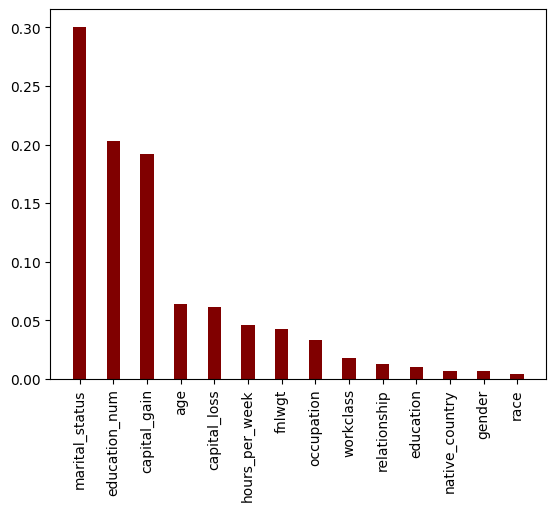

In [35]:
plt.bar(features, importances, color ='maroon',width = 0.4)
plt.xticks(rotation = 90)
plt.show()